# Advanced Machine Learning

### Assigment #7 - Time Series

**Team:**
    João Raimundo (57454), Rui Roque (57588)

### Import Libraries

In [16]:
import math
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import matplotlib.pyplot as plt


from datetime import datetime

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model



## 1. Problem 1 asdasdasdasdasd

### Creation of a time series for problem 1:

In [17]:
lag = 12
points = np.linspace(0, 2*math.pi*100, 50*100)
sin = np.sin(points)

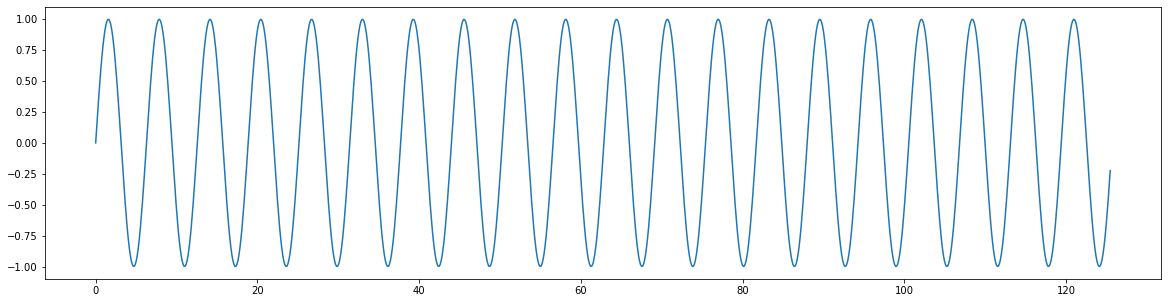

In [18]:
fig = plt.figure(figsize=(20,5))


# plot the function - first 
plt.plot(points[0:999], sin[0:999])
plt.show()

In [19]:
X = []
y = []

for i in range(lag, 4999):
   X.append(sin[i-lag:i])
   y.append(sin[i])

X = np.expand_dims(X, axis = 2)
y = np.array(y)

Split Data:

In [20]:
X_train_1 = X[:2400]
y_train_1 = y[:2400]
X_test_1  = X[2401:2501]
y_test_1  = y[2401:2501]

X_train_2 = X[2401:4900]
y_train_2 = y[2401:4900]
X_test_2  = X[4901:-1]
y_test_2  = y[4901:-1]

print("Shape of sets: \n")
print("--> First Train and Test sets:")
print("X_train_1: ", X_train_1.shape)
print("y_train_1: ", y_train_1.shape)
print("X_test_1: ", X_test_1.shape)
print("y_test_1: ", y_test_1.shape,"\n")

print("--> Second Train and Test sets:")
print("X_train_2: ", X_train_2.shape)
print("y_train_2: ", y_train_2.shape)
print("X_test_2: ", X_test_2.shape)
print("y_test_2: ", y_test_2.shape)

Shape of sets: 

--> First Train and Test sets:
X_train_1:  (2400, 12, 1)
y_train_1:  (2400,)
X_test_1:  (100, 12, 1)
y_test_1:  (100,) 

--> Second Train and Test sets:
X_train_2:  (2499, 12, 1)
y_train_2:  (2499,)
X_test_2:  (85, 12, 1)
y_test_2:  (85,)


### LSTM Model (Long short-term memory):

In [21]:
def lstm(X_train, y_train, X_test, y_test, epochs, noise = False, noise_value = 0.05):
    if(noise == False):
        lstm_model = Sequential([
        layers.LSTM(12, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(12, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(12),
        layers.Dropout(0.2),
        layers.Dense(1)
        ])
    else:
        lstm_model = Sequential([
        layers.GaussianNoise(noise_value),
        layers.LSTM(12, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(12, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(12),
        layers.Dropout(0.2),
        layers.Dense(1)
        ])    


    # compile
    lstm_model.compile(optimizer = 'adam', loss = keras.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

    print("LSTM Model contructed with 3 hidden layers of 12 neurons:\n")

    # Fitting the RNN to the Training set
    print("Currently fitting the model with the training set with", epochs, " epochs:")
    history_lstm = lstm_model.fit(X_train,y_train,epochs = epochs)

    print("\n")

    # plot loss plot
    plt.plot(history_lstm.history['loss'], label="loss")
    plt.legend(loc="upper right")
    plt.title("Loss Plot")
    plt.show()

    # inferring MSE % RMSE
    predictions = lstm_model.predict(X_test)
    test_score = mean_squared_error(y_test, predictions)
    print('LSTM Model Test MSE: %.3f' % test_score)
    print('LSTM Model Test RMSE: %.3f' % sqrt(test_score))

    # plot predictions and expected results
    fig = plt.figure(figsize=(40,10))
    plt.plot(y_train,  label="Train")
    plt.plot([None for i in y_train] + [x for x in y_test], label="Test")
    plt.plot([None for i in y_train] + [x for x in predictions], label="Predicted")
    plt.legend(loc="upper left", prop= {"size": 15}) 
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title("Train, Test and Predicted Results")
    plt.show()


### Set 1

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
Epoch 1/10
75/75 [==============================] - 4s 10ms/step - loss: 0.3294 - mean_absolute_error: 0.5137
Epoch 2/10
75/75 [==============================] - 1s 10ms/step - loss: 0.0979 - mean_absolute_error: 0.2534
Epoch 3/10
75/75 [==============================] - 1s 9ms/step - loss: 0.0359 - mean_absolute_error: 0.1476
Epoch 4/10
75/75 [==============================] - 1s 9ms/step - loss: 0.0315 - mean_absolute_error: 0.1375
Epoch 5/10
75/75 [==============================] - 1s 9ms/step - loss: 0.0267 - mean_absolute_error: 0.1287
Epoch 6/10
75/75 [==============================] - 1s 9ms/step - loss: 0.0250 - mean_absolute_error: 0.1239
Epoch 7/10
75/75 [==============================] - 1s 9ms/step - loss: 0.0222 - mean_absolute_error: 0.1161
Epoch 8/10
75/75 [==============================] - 1s 9ms/step - loss: 0.0222 - mean_absolute_error: 0.1164


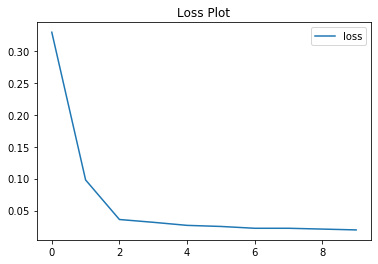

LSTM Model Test MSE: 0.001
LSTM Model Test RMSE: 0.028


/home/redck/.local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


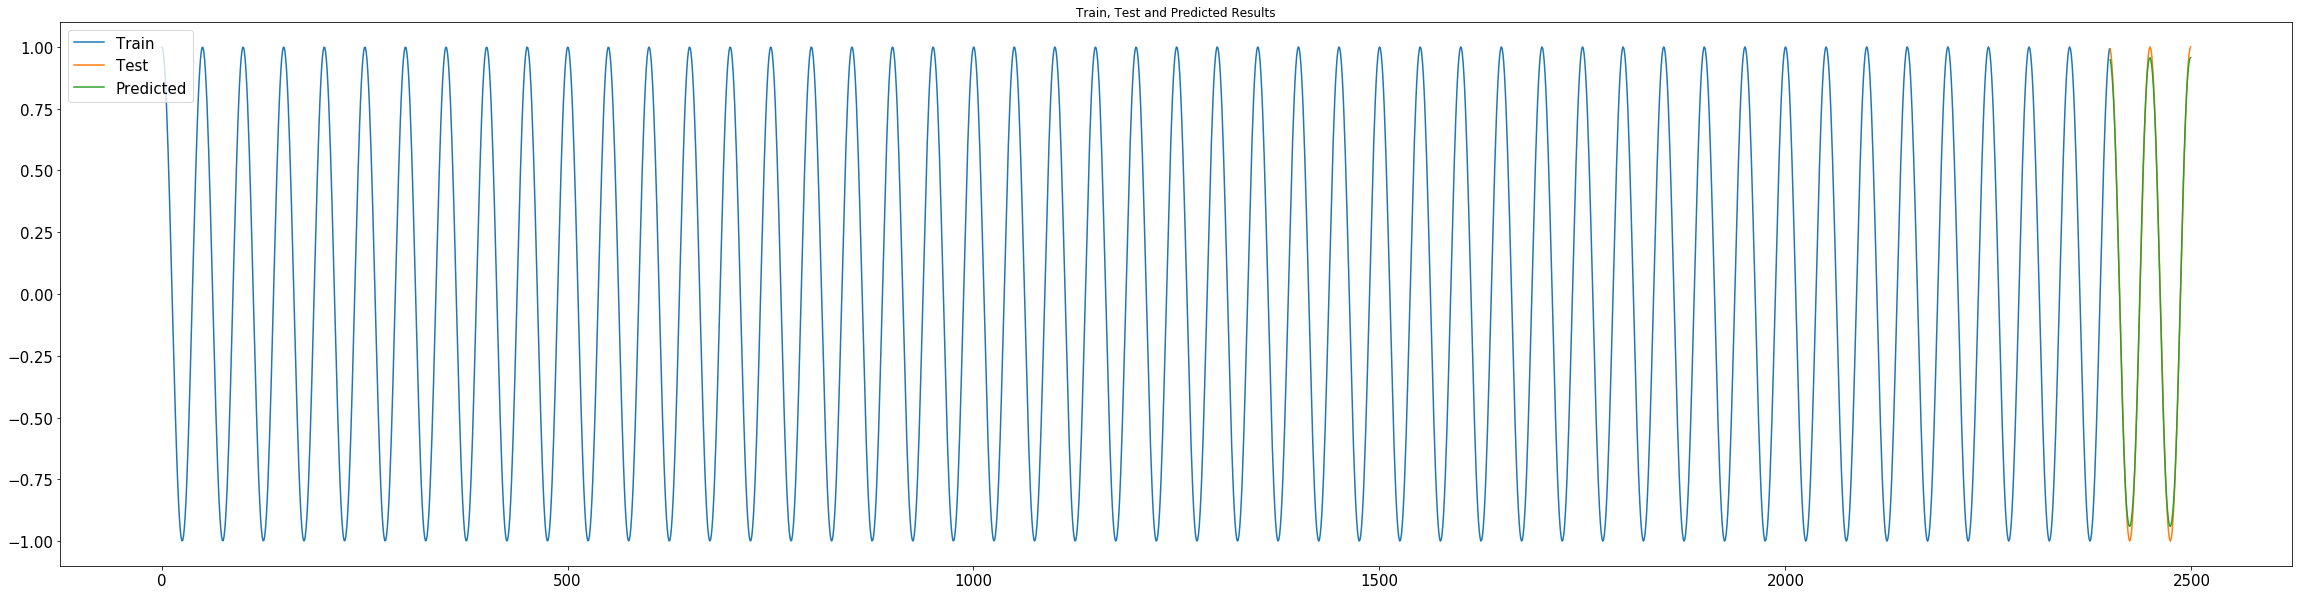

In [22]:
lstm(X_train_1, y_train_1, X_test_1, y_test_1, 10)

### Set 2:

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
Epoch 1/10
79/79 [==============================] - 5s 13ms/step - loss: 0.3339 - mean_absolute_error: 0.5202
Epoch 2/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0935 - mean_absolute_error: 0.2472
Epoch 3/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0396 - mean_absolute_error: 0.1567
Epoch 4/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0308 - mean_absolute_error: 0.1373
Epoch 5/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0272 - mean_absolute_error: 0.1298
Epoch 6/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0266 - mean_absolute_error: 0.1280
Epoch 7/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0233 - mean_absolute_error: 0.1193
Epoch 8/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0221 - mean_absolute_error: 0

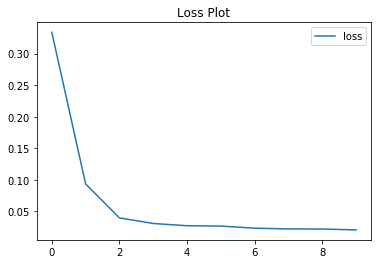

LSTM Model Test MSE: 0.001
LSTM Model Test RMSE: 0.032


/home/redck/.local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


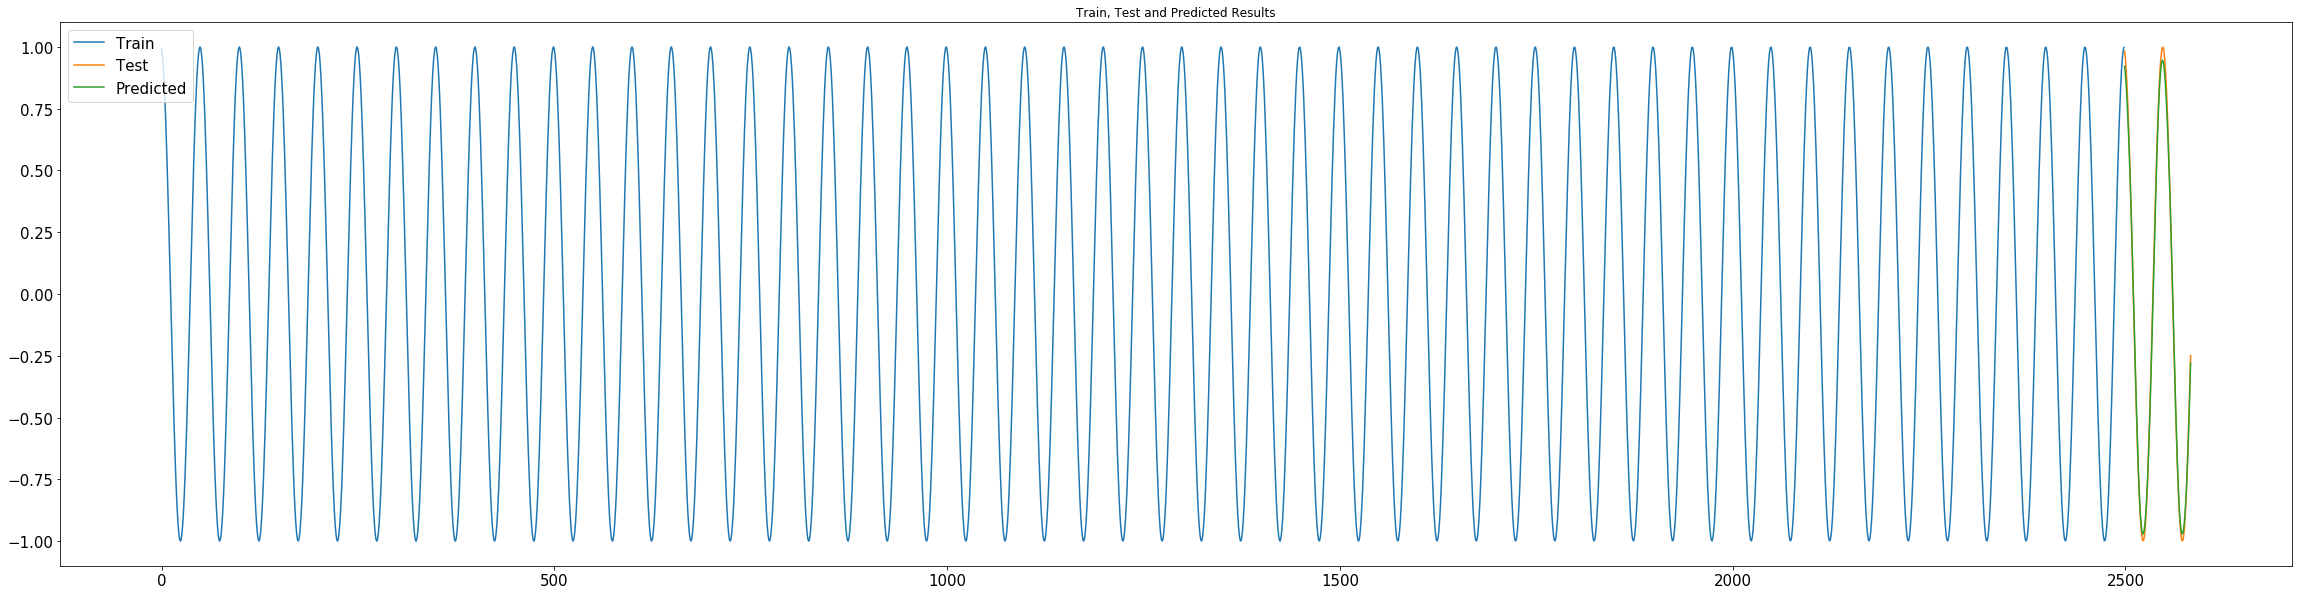

In [23]:
lstm(X_train_2, y_train_2, X_test_2, y_test_2, 10)

### II) learn using the above models the time series with noise: 

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
Epoch 1/10
75/75 [==============================] - 6s 10ms/step - loss: 0.3391 - mean_absolute_error: 0.5243
Epoch 2/10
75/75 [==============================] - 1s 13ms/step - loss: 0.1254 - mean_absolute_error: 0.2936
Epoch 3/10
75/75 [==============================] - 1s 10ms/step - loss: 0.0360 - mean_absolute_error: 0.1505
Epoch 4/10
75/75 [==============================] - 1s 14ms/step - loss: 0.0298 - mean_absolute_error: 0.1364
Epoch 5/10
75/75 [==============================] - 1s 12ms/step - loss: 0.0271 - mean_absolute_error: 0.1298
Epoch 6/10
75/75 [==============================] - 1s 12ms/step - loss: 0.0258 - mean_absolute_error: 0.1260
Epoch 7/10
75/75 [==============================] - 1s 10ms/step - loss: 0.0257 - mean_absolute_error: 0.1246
Epoch 8/10
75/75 [==============================] - 1s 9ms/step - loss: 0.0247 - mean_absolute_error: 0.

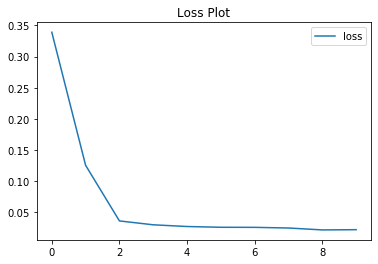

LSTM Model Test MSE: 0.002
LSTM Model Test RMSE: 0.043


/home/redck/.local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


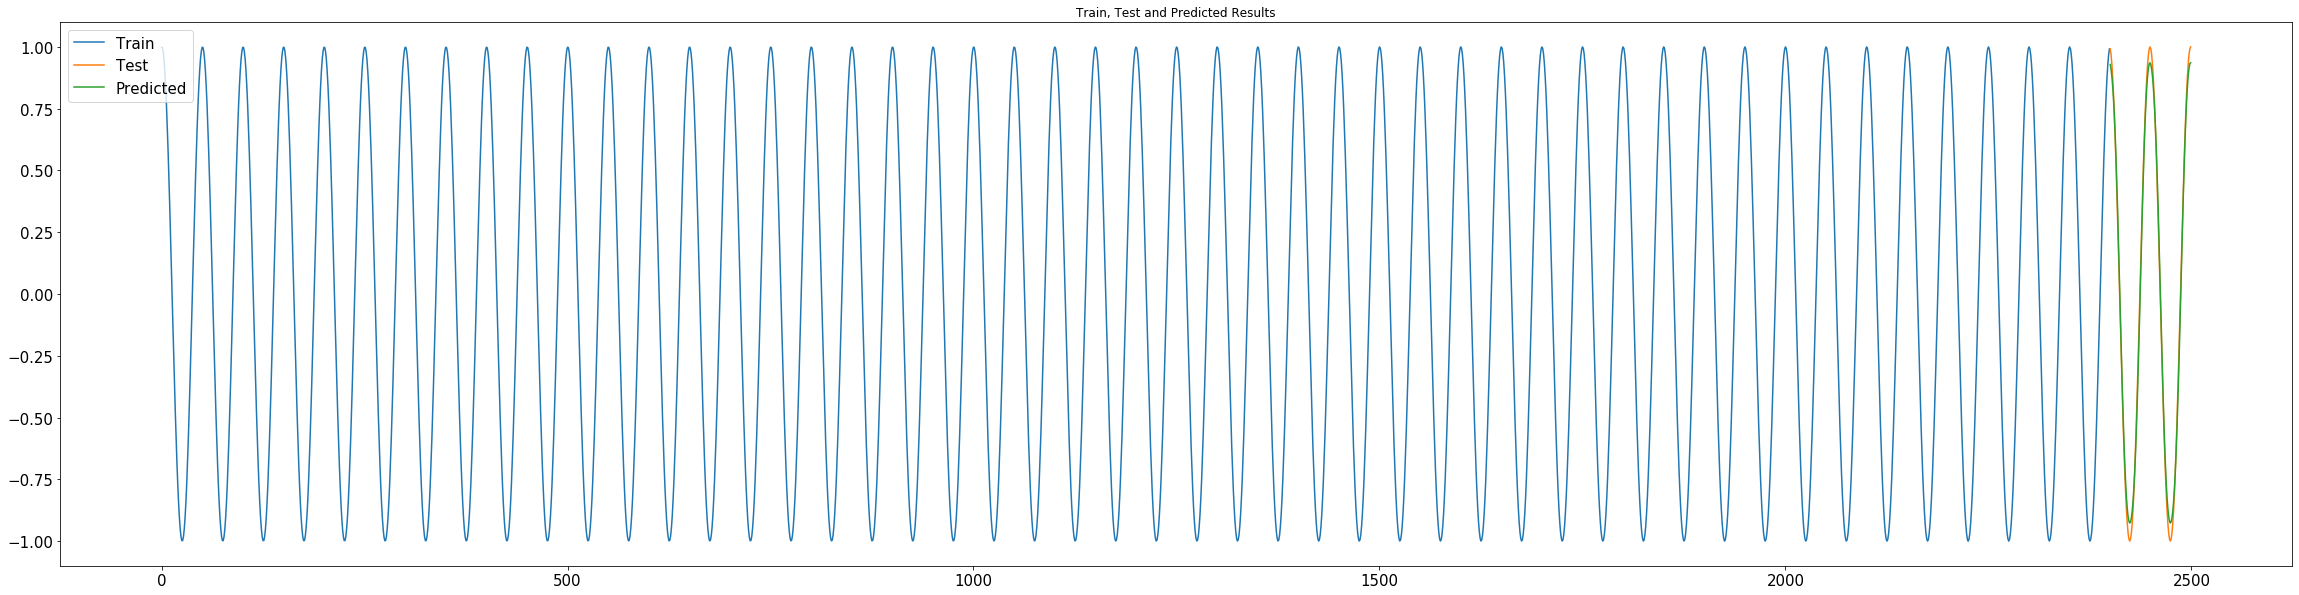

In [24]:
lstm(X_train_1, y_train_1, X_test_1, y_test_1, 10, True)

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
Epoch 1/10
79/79 [==============================] - 7s 15ms/step - loss: 0.3648 - mean_absolute_error: 0.5449
Epoch 2/10
79/79 [==============================] - 1s 12ms/step - loss: 0.1394 - mean_absolute_error: 0.3102
Epoch 3/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0363 - mean_absolute_error: 0.1503
Epoch 4/10
79/79 [==============================] - 1s 13ms/step - loss: 0.0300 - mean_absolute_error: 0.1356
Epoch 5/10
79/79 [==============================] - 1s 14ms/step - loss: 0.0244 - mean_absolute_error: 0.1222
Epoch 6/10
79/79 [==============================] - 1s 13ms/step - loss: 0.0255 - mean_absolute_error: 0.1251
Epoch 7/10
79/79 [==============================] - 1s 14ms/step - loss: 0.0220 - mean_absolute_error: 0.1164
Epoch 8/10
79/79 [==============================] - 1s 14ms/step - loss: 0.0210 - mean_absolute_error: 0

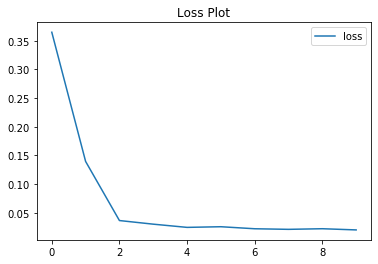

LSTM Model Test MSE: 0.001
LSTM Model Test RMSE: 0.034


/home/redck/.local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


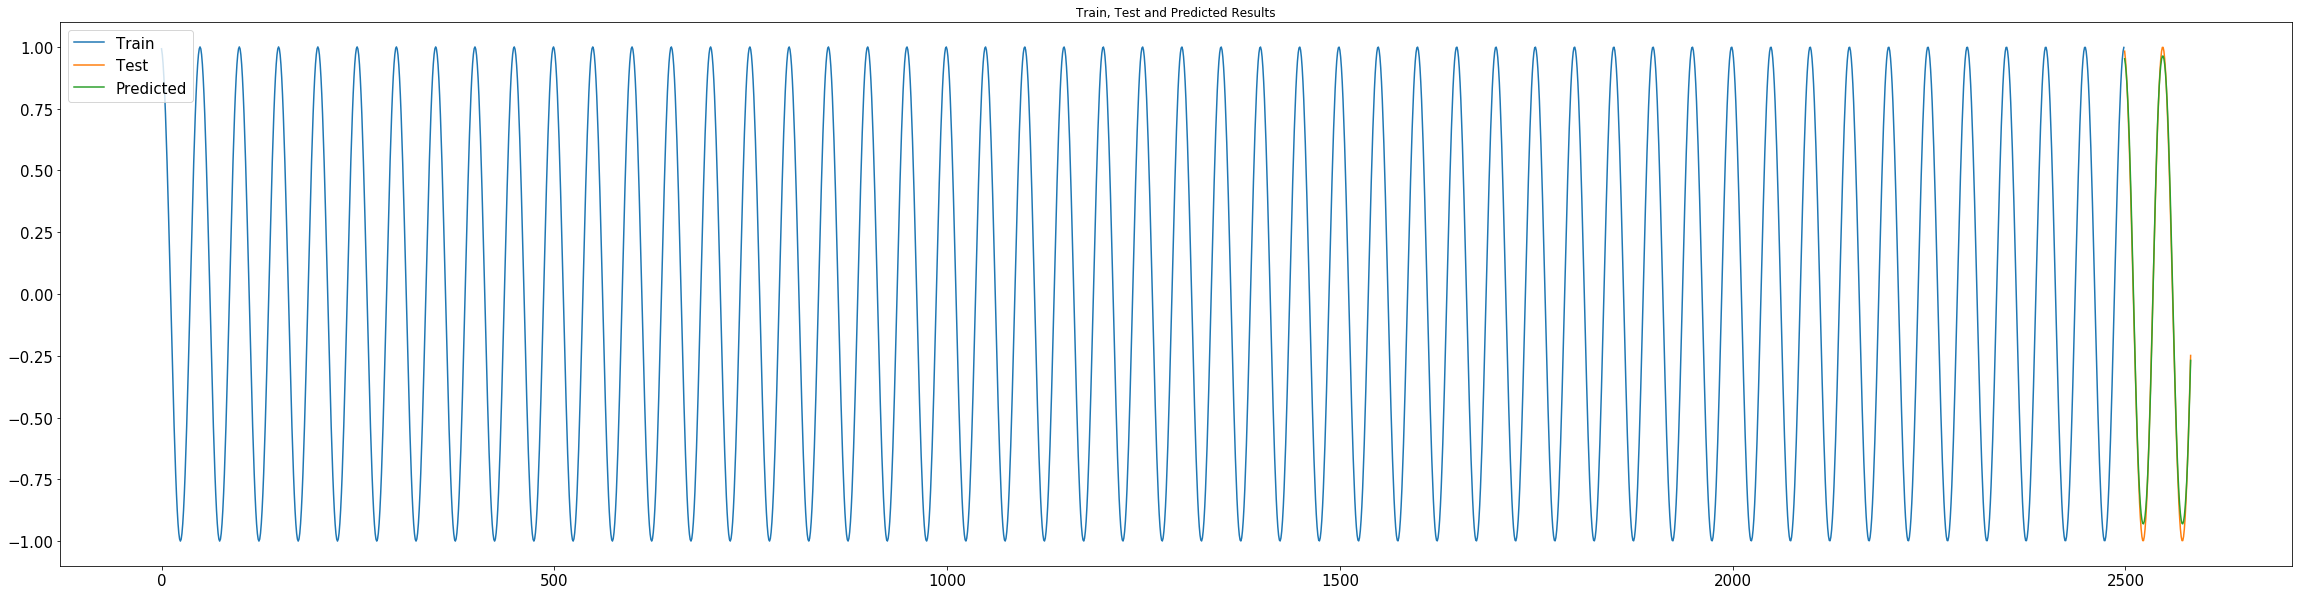

In [25]:
lstm(X_train_2, y_train_2, X_test_2, y_test_2, 10, True)

### Performance

### FTLFN Model:

In [37]:
def ftlfn(X_train, y_train, X_test, y_test, epochs, noise = False, noise_value = 0.05):

    train_performance, test_performance = list(), list()
    
    if(noise == False):
        ftlfn_model = Sequential([
        layers.Dense(12, activation='relu'),
        layers.Dense(1)
        ])
    else:
        ftlfn_model = Sequential([
        layers.GaussianNoise(noise_value),
        layers.Dense(12, activation='relu'),
        layers.Dense(1)
        ])


    # compile
    ftlfn_model.compile(optimizer = 'adam', loss = keras.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

    print("LSTM Model contructed with 3 hidden layers of 12 neurons:\n")

    # Fitting the RNN to the Training set
    print("Currently fitting the model with the training set with", epochs, " epochs:")
    for i in range(epochs):
        history_ftlfn = ftlfn_model.fit(X_train,y_train,epochs = 1)
        
        train_performance.append(ftlfn_model.evaluate(X_train, y_train, verbose=0)[0])
        test_performance.append(ftlfn_model.evaluate(X_test_1, y_test_1, verbose = 0)[0])

    performance = pd.DataFrame()
    performance["train_mse"], performance["test_mse"] = train_performance, test_performance

    return performance
    

In [27]:
def run_ftlfn(X_train, y_train, X_test, y_test, repeats, epochs, noise = False, noise_value = 0.05):

    for i in range(repeats):
        history = ftlfn(X_train, y_train, X_test, y_test, epochs)
        plt.plot(history['train_mse'], color='blue')
        plt.plot(history['test_mse'], color='orange')
        print('%d) TrainMSE=%f, TestMSE=%f' % (i, history['train_mse'].iloc[-1], history['test_mse'].iloc[-1]))


    
 
    
    

### Model FTLFN Without noise:

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5005 - mean_absolute_error: 0.6367
0) TrainMSE=0.497495, TestMSE=0.496474
LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 2ms/step - loss: 0.5004 - mean_absolute_error: 0.6367
1) TrainMSE=0.497485, TestMSE=0.495928
LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 2ms/step - loss: 0.5006 - mean_absolute_error: 0.6368
2) TrainMSE=0.497671, TestMSE=0.497042
LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5018 - mean_absolute_e

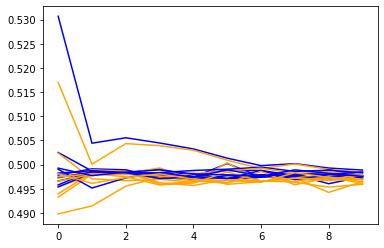

In [28]:
run_ftlfn(X_train_1, y_train_1, X_test_1, y_test_1, 10, 10)


### Model FTLFN With noise:

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5006 - mean_absolute_error: 0.6367
0) TrainMSE=0.497629, TestMSE=0.496681
LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5011 - mean_absolute_error: 0.6372
1) TrainMSE=0.497415, TestMSE=0.496093
LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5011 - mean_absolute_error: 0.6369
2) TrainMSE=0.499259, TestMSE=0.499532
LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 2ms/step - loss: 0.5015 - mean_absolute_e

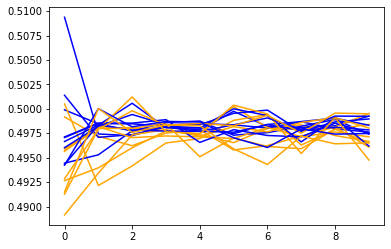

In [29]:
run_ftlfn(X_train_1, y_train_1, X_test_1, y_test_1, 10, 10, True)


## Problem 2

### Creation of a time series for problem 2:

In [43]:
data = [5,6,3]
X = []
y = []

for i in range(4997):
    out = (0.6*data[i+2]) + (-0.54*data[i+1]) + (-0.44*data[i]) #+ 0.01 (U)
    data.append(out)

print(len(data))

for i in range(lag, 4999):
   X.append(data[i-lag:i])
   y.append(data[i])

X = np.expand_dims(X, axis = 2)
y = np.array(y)

print(len(X))

X_train_1 = X[:2400]
y_train_1 = y[:2400]
X_test_1  = X[2401:2501]
y_test_1  = y[2401:2501]

X_train_2 = X[2401:4900]
y_train_2 = y[2401:4900]
X_test_2  = X[4901:-1]
y_test_2  = y[4901:-1]


5000
4987


LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 50  epochs:
Epoch 1/50
75/75 [==============================] - 4s 11ms/step - loss: nan - mean_absolute_error: nan
Epoch 2/50
75/75 [==============================] - 1s 9ms/step - loss: nan - mean_absolute_error: nan
Epoch 3/50
75/75 [==============================] - 1s 9ms/step - loss: nan - mean_absolute_error: nan
Epoch 4/50
75/75 [==============================] - 1s 8ms/step - loss: nan - mean_absolute_error: nan
Epoch 5/50
75/75 [==============================] - 1s 8ms/step - loss: nan - mean_absolute_error: nan
Epoch 6/50
75/75 [==============================] - 1s 10ms/step - loss: nan - mean_absolute_error: nan
Epoch 7/50
75/75 [==============================] - 1s 10ms/step - loss: nan - mean_absolute_error: nan
Epoch 8/50
75/75 [==============================] - 1s 9ms/step - loss: nan - mean_absolute_error: nan
Epoch 9/50
75/75 [=============================

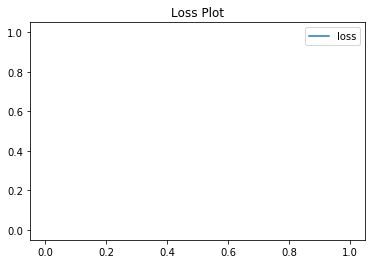

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [44]:
lstm(X_train_1, y_train_1, X_test_1, y_test_1, 50, True, 0.01)

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 50  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 5.7836 - mean_absolute_error: 1.9430
0) TrainMSE=5.783063, TestMSE=0.587740
LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 50  epochs:
75/75 [==============================] - 0s 2ms/step - loss: 5.7848 - mean_absolute_error: 1.9430
1) TrainMSE=5.782791, TestMSE=0.587818
LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 50  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 5.7847 - mean_absolute_error: 1.9431
2) TrainMSE=5.782737, TestMSE=0.587845
LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 50  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 5.7848 - mean_absolute_e

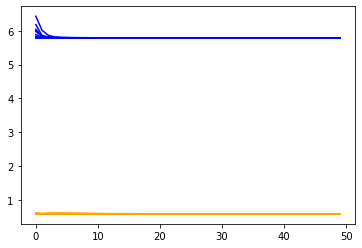

In [ ]:
run_ftlfn(X_train_1, y_train_1, X_test_1, y_test_1,10, 50, True, 0.01)

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 50  epochs:
Epoch 1/50
79/79 [==============================] - 6s 14ms/step - loss: 0.1642 - mean_absolute_error: 0.3248
Epoch 2/50
79/79 [==============================] - 1s 13ms/step - loss: 0.0902 - mean_absolute_error: 0.2334
Epoch 3/50
79/79 [==============================] - 1s 14ms/step - loss: 0.0433 - mean_absolute_error: 0.1562
Epoch 4/50
79/79 [==============================] - 1s 14ms/step - loss: 0.0318 - mean_absolute_error: 0.1326
Epoch 5/50
79/79 [==============================] - 1s 13ms/step - loss: 0.0250 - mean_absolute_error: 0.1177
Epoch 6/50
79/79 [==============================] - 1s 14ms/step - loss: 0.0241 - mean_absolute_error: 0.1169
Epoch 7/50
79/79 [==============================] - 1s 16ms/step - loss: 0.0224 - mean_absolute_error: 0.1129
Epoch 8/50
79/79 [==============================] - 1s 14ms/step - loss: 0.0218 - mean_absolute_error: 0

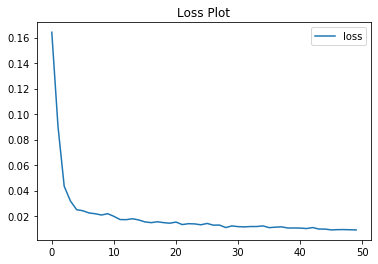

LSTM Model Test MSE: 0.000
LSTM Model Test RMSE: 0.008


/home/redck/.local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


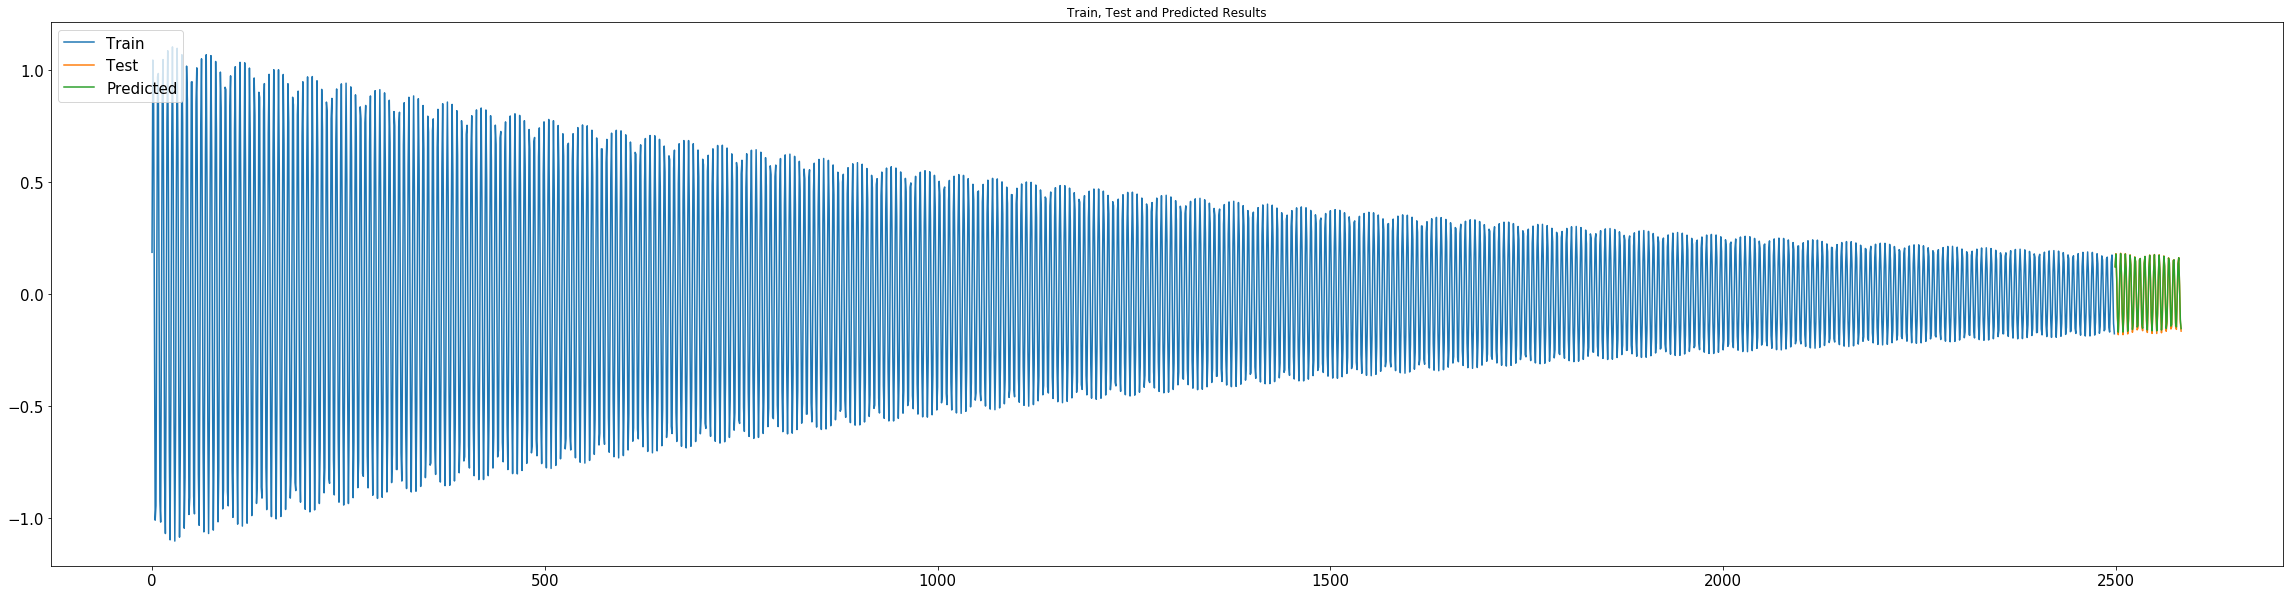

In [ ]:
lstm(X_train_2, y_train_2, X_test_2, y_test_2, 50, True, 0.01)

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 50  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.1703 - mean_absolute_error: 0.3307
0) TrainMSE=0.170096, TestMSE=0.587689
LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 50  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.1702 - mean_absolute_error: 0.3307
1) TrainMSE=0.170195, TestMSE=0.588272
LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 50  epochs:
79/79 [==============================] - 0s 3ms/step - loss: 0.1702 - mean_absolute_error: 0.3307
2) TrainMSE=0.170101, TestMSE=0.587835
LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 50  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.1702 - mean_absolute_e

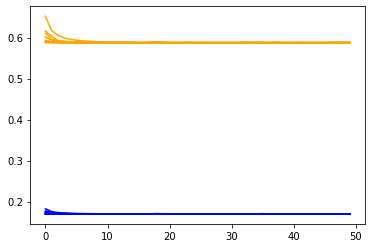

In [ ]:
run_ftlfn(X_train_2, y_train_2, X_test_2, y_test_2,10, 50, True, 0.01)